# Spam Filtering Using Gaussian Naive Bayes
---
Use the `spambase.data` file and the Gaussian Naive Bayes algorithm to build a simple spam detection algorithm. You can get accuracies around 80% with this simple classifier that is quickly trained.

In [415]:
%matplotlib inline
import pandas as pd
import sklearn, sklearn.model_selection
import numpy as np
import matplotlib.pyplot as plt
import itertools

## Read the data

---

We need to read in the data from the spambase.data which is in CSV format. Pandas is perfect for this. If you look at the spambase.data file, you'll notice that there are no column headers and that the identification for spam vs. non-spam is found in column 57. So make sure you set the `header` argument to `None` and the `index_col` argument to `57`.

In [416]:
data = pd.read_csv('~/data/spam.data/spambase.data', header=None, index_col=57)

## Split the data

---

Now we want to split the data into training and testing sets. Scikit-learn has a great function for this: `sklearn.model_selection.train_test_split()`. The first parameter is the data to split, `data` in my case. We need to make sure to tell it to split the training and testing set in half by passing `0.5` to the `test_size` argument. Also, set the `random_state` argument to `np.random.RandomState()` so that the data is shuffled. (This is important since `spambase.data` is sorted by class).

In [417]:
X_train, X_test = sklearn.model_selection.train_test_split(data, test_size=0.5, random_state = np.random.RandomState())

## Get the prior probabilities

---

Note that the `spambase.data` file has approximately 40% of the emails categorized as spam, so our split should reflect that. Since the `train_test_split()` function returned our split training and testing sets as pandas dataframes and since we set the index column to be the class of the instance, when we say `X_train.loc[1]` we are selecting all of the rows in the training set that have class 1. That is, select all the spam instances. Similarly, we can select all the non-spam (or ham) instances by doing `X_train.loc[0]`. 

In [418]:
prob_spam_train = len(X_train.loc[1].index)/len(X_train.index)
prob_spam_train

0.391304347826087

In [419]:
prob_ham_train = len(X_train.loc[0].index) / len(X_train.index)
prob_ham_train

0.6086956521739131

## Get the means and the standard deviations over the columns

---

In order to calculate the probability (which we simulate with the probability density function), we need to have the mean and standard deviation of each column for a given class (spam or ham). This is made quite easy by using the pandas [`describe()` function](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html). The result of `describe()` is a dataframe and to get the column means or standard deviations, we merely need to index the row labeled `mean` or `std` respectively.

In [420]:
train_spam_col_means = X_train.loc[1].describe().loc['mean']

In [421]:
train_spam_col_stds = X_train.loc[1].describe().loc['std']

In [422]:
train_ham_col_means = X_train.loc[0].describe().loc['std']

In [423]:
train_ham_col_stds = X_train.loc[0].describe().loc['std']

## Define a function to calculate the sum of the log of the probabilities

---

This function returns the result of the following equation:

$$\log{P(\textit{class})} + \sum_i \log{P(x_i \text{ | } \textit{class})}$$

Where 

$$P(x_i \text{ | } c_j) = N(x_i ; \mu_{i,c_j} , \sigma_{i, c_j})$$

and

$$N(x; \mu , \sigma) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$ 

Again, Pandas makes this easy. It'll be the case that `x`, `mus`, and `sigmas` are all pandas dataframes with 1 row and 57 columns, so we can add, subtract, multiply, eponentiate, log, or divide on an item-by-item basis. So `x - mus` is also a 1 x 57 dataframe, for example. Additionally, the pandas `sum()` function ignores `NaN` values by default, so there isn't anything we need to do to avoid them (i.e. when the std is 0).

In [424]:
def sum_of_log_probs(P_class, x, mus, sigmas):
    return np.log(P_class) + np.log((1 / (np.sqrt(2 * np.pi) * sigmas)) * np.exp(-((x - mus)**2 / (2 * sigmas**2)))).sum()

## Given an instance `x`, predict its class

---

Determine a class of an instance. Calculate the following

$$class_{NB}\big(\overrightarrow{\mathbf{x}}\big) = \underset{\textit{class} \in \{0, 1\}}{\mathrm{argmax}} \Big(\log{P(\textit{class})} + \sum_i \log{P(x_i \text{ | } \textit{class})} \Big)$$

where $P(x_i \text{ | } c_j)$ is as given previously.

In [425]:
def predict(x):
    pos = sum_of_log_probs(prob_spam_train, x, train_spam_col_means, train_spam_col_stds)
    neg = sum_of_log_probs(prob_ham_train, x, train_ham_col_means, train_ham_col_stds)
    return 1 if pos > neg else 0

## Classify all instances in the test set

---

Walk over the test set predicting each of the instances. Here's another time when pandas makes this nice. The `pandas.DataFrame.iterrows()` function returns a tuple `(index, row dataframe)`. So we have the actual value, which is stored in the index column since that's what was set by the `index_col` argument of the `pandas.read_csv()` function.

*Note: `numpy.log()` will return a runtime warning if the value it gets is equal to 0.0. It is fine for us to ignore this.*

In [426]:
cm = np.zeros((2,2), dtype=np.int)  # Define a blank confusion matrix
num_correct = 0
for actual, x in X_test.iterrows():
    predicted = predict(x)
    if actual == predicted:
        num_correct += 1
    cm[actual][predicted] += 1
print('accuracy: {} / {} = {:.4f}\n'.format(num_correct, len(X_test.index), num_correct / len(X_test.index)))
print(cm)

/usr/local/var/pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


accuracy: 1809 / 2301 = 0.7862

[[949 439]
 [ 53 860]]


In [427]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

## Plot the confusion matrix

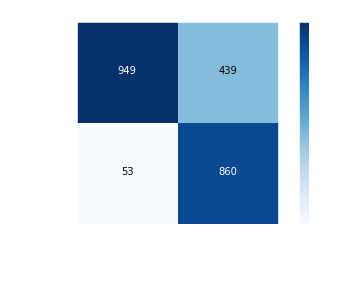

In [428]:
plt.figure()
plot_confusion_matrix(cm, classes=('spam', 'not_spam'), title='Confusion matrix')